## Classificação de imagens de frutas e vegetais frescos e estragados

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

### iterar pelas pastas para criar um dataframe da forma: caminho e nome dos arquivos

In [2]:
sdir=r'../input/fresh-and-stale-images-of-fruits-and-vegetables'

filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)                   
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths       labels
0  ../input/fresh-and-stale-images-of-fruits-and-...  stale_apple
1  ../input/fresh-and-stale-images-of-fruits-and-...  stale_apple
2  ../input/fresh-and-stale-images-of-fruits-and-...  stale_apple
3  ../input/fresh-and-stale-images-of-fruits-and-...  stale_apple
4  ../input/fresh-and-stale-images-of-fruits-and-...  stale_apple
stale_apple           2342
fresh_apple           1693
stale_orange          1595
fresh_banana          1581
stale_banana          1467
fresh_orange          1466
fresh_capsicum         990
stale_tomato           982
fresh_tomato           981
stale_capsicum         901
stale_bitter_gourd     357
fresh_bitter_gourd     327
Name: labels, dtype: int64


### o conjunto de dados está moderadamente balanceado - dividir df em train_df, test_df e valid_df

In [3]:
train_split=.9
test_split=.05
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('quantidade para treinamento:', len(train_df), 
       '\nquantidade para teste:', len(test_df), 
       '\nquantidade para validação:', len(valid_df))

quantidade para treinamento: 13213 
quantidade para teste: 734 
quantidade para validação: 735


### criar geradores de treinamento, teste e validação

In [4]:
height=128
width=128
channels=3
batch_size=40
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'tamanho do lote de teste:' ,test_batch_size, '  etapas de teste:', test_steps)
def scalar(img):
    return img/127.5-1  # dimensiona o pixel entre -1 e +1
gen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=gen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen=gen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)

tamanho do lote de teste: 2   etapas de teste: 367
Found 13213 validated image filenames belonging to 12 classes.
Found 734 validated image filenames belonging to 12 classes.
Found 735 validated image filenames belonging to 12 classes.
['fresh_apple', 'fresh_banana', 'fresh_bitter_gourd', 'fresh_capsicum', 'fresh_orange', 'fresh_tomato', 'stale_apple', 'stale_banana', 'stale_bitter_gourd', 'stale_capsicum', 'stale_orange', 'stale_tomato']


###   conjunto de dados balanceado - determinar o dicionário class_weight dictionary baseado nas amostras do conjunto de treinamento por classe

In [5]:
class_weight={}
train_dict=train_gen.class_indices
classes=list(train_dict.keys())
class_count=len(classes)
labels=train_gen.labels
count_array=np.zeros((class_count))
for label in labels:
    for value in train_dict.values():
        if label==value:
            count_array[value] +=1    
max_samples=np.max(count_array)
msg='{0:^30s}{1:^10s}{2:^9s}'.format('Classe', 'Amostras', 'Peso')
print(msg)
for i in range (class_count):
    class_weight[i]= max_samples/count_array[i]
    msg=f'{classes[i]:^30s}{str(count_array[i]):^10s}{class_weight[i]:^9.5f}'
    print (msg)


            Classe             Amostras   Peso   
         fresh_apple            1502.0   1.40613 
         fresh_banana           1423.0   1.48419 
      fresh_bitter_gourd        304.0    6.94737 
        fresh_capsicum          876.0    2.41096 
         fresh_orange           1345.0   1.57026 
         fresh_tomato           892.0    2.36771 
         stale_apple            2112.0   1.00000 
         stale_banana           1316.0   1.60486 
      stale_bitter_gourd        318.0    6.64151 
        stale_capsicum          791.0    2.67004 
         stale_orange           1446.0   1.46058 
         stale_tomato           888.0    2.37838 


### criar função para mostrar alguns exemplos de imagem

In [6]:
def show_image_samples(gen ):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen) # obtém um lote de amostra do gerador
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   # mostra no máximo 25 imagens
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=(images[i]+1 )/2 # dimensiona as imagens entre 0 e 1 porque o pré-processador as define entre -1 e +1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

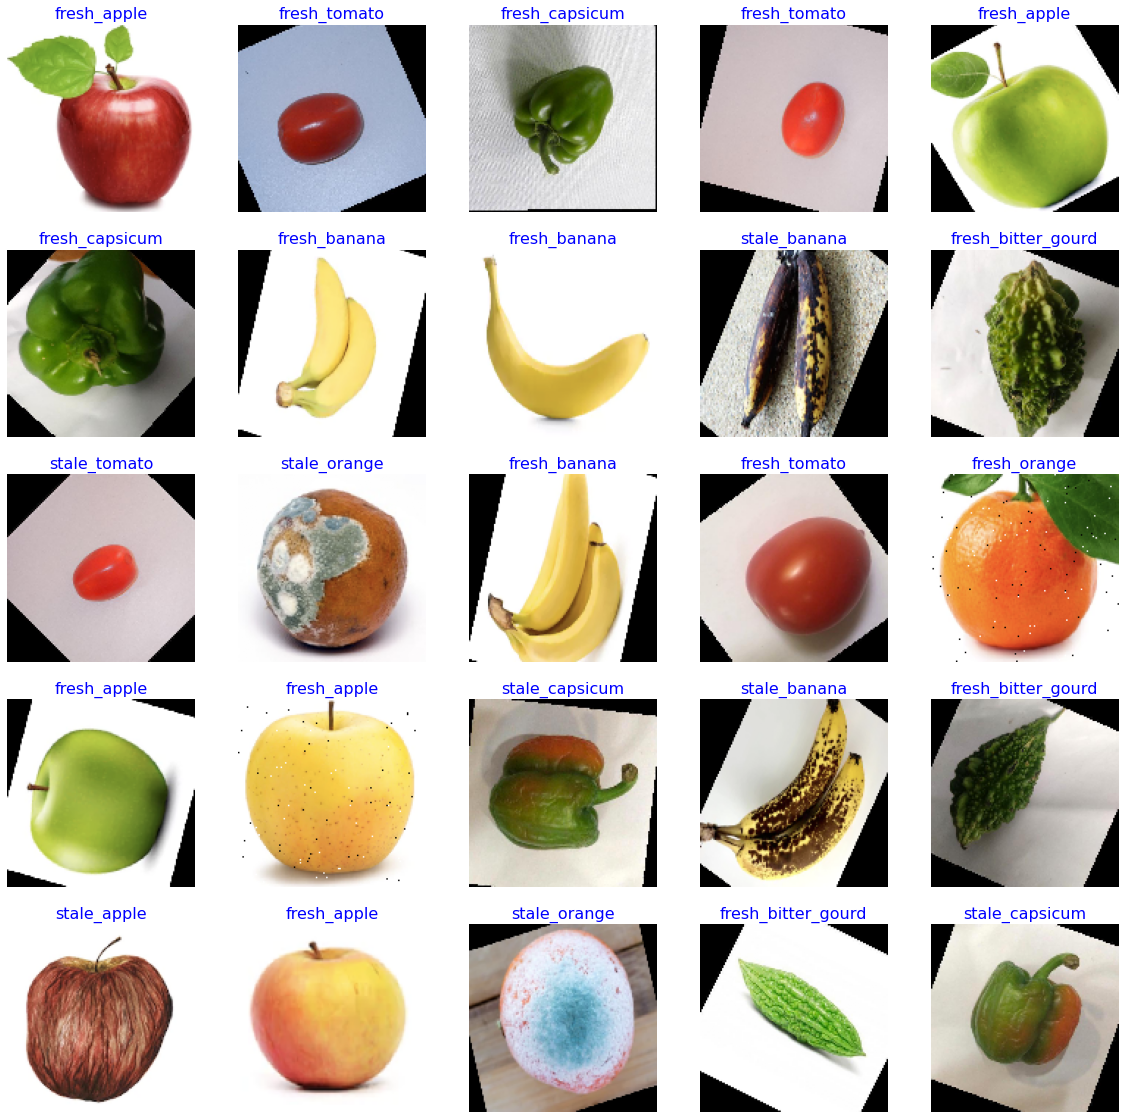

In [7]:
show_image_samples(train_gen)

### definir função para imprimir texto em cores RGB com background

In [8]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    # imprime o texto na cor especificada por fore_tupple com o background especificado por back_tupple
    # text_msg é o texto, fore_tupple é a tupla de cor do texto (r,g,b), back_tupple é a tupla de cor do background (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # retorna a cor de impressão padrão para preto
    return

### criar o modelo

In [9]:
model_name='InceptionResNetV2'
base_model=tf.keras.applications.InceptionResNetV2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

219062272/219055592 [==============================] - 4s 0us/step


### criar uma subclasse de retornos de chamada para controlar a taxa de aprendizado e imprimir os resultados do treinamento para cada iteração

In [10]:
class LRA(keras.callbacks.Callback):
    reset=False
    count=0
    stop_count=0
    tepochs=0
    def __init__(self,model, patience,stop_patience, threshold, factor, dwell, model_name, freeze, initial_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.patience=patience # especifica quantas iterações sem melhoria existem antes que a taxa de aprendizado seja ajustada
        self.stop_patience=stop_patience
        self.threshold=threshold # especifica o limite de acurácia do treinamento quando a taxa de aprendizado for ajustada baseado na perda de validação
        self.factor=factor # fator para reduzir a taxa de aprendizagem
        self.dwell=dwell
        self.lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # obtém a taxa de aprendizado inicial e salva-a em self.lr
        self.highest_tracc=0.0 # define a maior acurácia de treinamento para 0
        self.lowest_vloss=np.inf # define a menor perda de validação para infinito
        self.initial_epoch=initial_epoch 
        best_weights=self.model.get_weights() # define uma classe disponível para que os pesos possam ser carregados após o treinamento ser concluído        
        msg=' '
        if freeze==True:
            msgs=f' Iniciando o treinamento usando o modelo base { model_name} com pesos congelados em pesos de imagenet inicializando o callback LRA'
        else:
            msgs=f' Iniciando o treinamento usando o modelo base { model_name} treinando todas as camadas'            
        print_in_color (msgs, (244, 252, 3), (55,65,80)) 
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  # o método executa ao final de cada iteração
        later=time.time()
        duration=later-self.now        
        if epoch== self.initial_epoch or LRA.reset==True:  
            LRA.reset=False           
            msg='{0:^10s}{1:^7s}{2:^10s}{3:^20s}{4:^23s}{5:^21s}{6:^29s}{7:^15s}{8:^9s}'.format('Iteração', 'Perda', 'Acurácia',
                                                                                           'Perda de Validação','Acurácia de Validação', 
                                                                                           'Taxa de Aprendizado', 'Próxima Taxa de Aprendizado', 
                                                                                           'Monitoramento', 'Duração')
            print_in_color(msg, (244,252,3), (55,65,80)) 
            
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # obtém a taxa de aprendizado atual
        current_lr=lr
        v_loss=logs.get('val_loss')  # obtém a perda de validação para a iteração
        acc=logs.get('accuracy')  # obtém a acurácia de treinamento 
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')
        if acc < self.threshold: # se a acurácia do treinamento estiver abaixo do limite, ajustar lr com base na acurácia do treinamento
            monitor='accuracy'
            if acc>self.highest_tracc: # acurácia de treinamento melhorou na iteração                
                self.highest_tracc=acc # define a nova acurácia de treinamento mais alta
                LRA.best_weights=self.model.get_weights() # acurácia de treinamento melhorada, então salva os pesos
                self.count=0 # define o contador para 0, já que a acurácia do treinamento melhorou
                self.stop_count=0 # define o contador de parada para 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.lr=lr
            else: 
                # acurácia de treinamento não melhorou,verificar se isso aconteceu por uma quantidade de iterações = patience
                # se sim, ajustar a taxa de aprendizado
                if self.count>=self.patience -1:
                    color=(245, 170, 66)
                    self.lr= lr* self.factor # ajusta o aprendizado baseado no fator
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # define a taxa de aprendizado no otimizador
                    self.count=0 # reseta o contador para 0
                    self.stop_count=self.stop_count + 1
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # retorna ao melhor ponto no espaço N                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1 # incrementa o contador "patience"                   
        else: # acurácia de treinamento acima do limite, então ajustar a taxa de aprendizado baseado na perda de validação
            monitor='val_loss'
            if v_loss< self.lowest_vloss: # verifica se a perda de validação melhorou
                self.lowest_vloss=v_loss # substitui a menor perda de validação por uma nova perda de validação               
                LRA.best_weights=self.model.get_weights() # perda de validação melhorada, então salva os pesos
                self.count=0 # reseta o contador, já que a perda de validação melhorou  
                self.stop_count=0  
                color=(0,255,0)
                self.lr=lr
            else: # perda de validação não melhorou
                if self.count>=self.patience-1:
                    color=(245, 170, 66)
                    self.lr=self.lr * self.factor # ajusta a taxa de aprendizado
                    self.stop_count=self.stop_count + 1 # incrementa o contador de parada porque a taxa de aprendizado foi ajustada
                    self.count=0 # reseta o contador
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # define a taxa de aprendizado no otimizador
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # retorna ao melhor ponto no espaço N 
                else: 
                    self.count =self.count +1 # incrementa o contador "patience"                    
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(LRA.tepochs):5s} {loss:^8.3f}{acc*100:^9.3f}{v_loss:^19.5f}{v_acc*100:^22.3f}{current_lr:^21.5f}{self.lr:^29.5f}{monitor:^17s}{duration:^9.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: # verifica se a taxa de aprendizado foi ajustada "stop_count" vezes sem melhora
            msg=f' O treinamento foi interrompido na iteração {epoch + 1} depois de {self.stop_patience} ajustes de taxa de aprendizado sem melhora'
            print_in_color(msg, (0,255,0), (55,65,80))
            self.model.stop_training = True # para o treinamento

### instanciar o callback customizado e treinar o modelo

In [11]:
epochs=10
patience=1 # número de iterações a esperar para ajustar a taxa de aprendizado se o valor monitorado não melhorar
stop_patience=3 # número de iterações a esperar antes de interromper o treinamento se o valor monitorado não melhorar
threshold=.9 # se a acurácia do treinamento for menor que o limiar, ajusta a acurácia do monitor, caso contrário, ajusta da perda de validação do monitor
factor=.5 # fator para reduzir a taxa de aprendizado
dwell=True # experimental, se True e a métrica monitorada não melhora na iteração atual, define os pesos do modelo de volta aos pesos da iteração anterior
freeze=False # se True, libera os pesos do modelo base

callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, model_name=model_name, freeze=freeze, initial_epoch=0 )]
LRA.tepochs=epochs  # usado para determinar o valor da última iteração para impressão
history=model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0, class_weight=class_weight)

 Iniciando o treinamento usando o modelo base InceptionResNetV2 treinando todas as camadas

 Iteração  Perda  Acurácia  Perda de Validação  Acurácia de Validação  Taxa de Aprendizado  Próxima Taxa de Aprendizado  Monitoramento  Duração 

 1 /10     7.014   92.386        5.18728              99.184               0.00100                  0.00100               val_loss      2440.84 

 2 /10     4.230   99.402        3.23353              99.728               0.00100                  0.00100               val_loss      2357.69 

 3 /10     2.587   99.553        1.88949             100.000               0.00100                  0.00100               val_loss      2359.89 

 4 /10     1.509   99.826        1.07565             100.000               0.00100                  0.00100               val_loss      2359.46 

 5 /10     0.875   99.796        0.60747             100.000               0.00100                  0.00100               val_loss      2343.19 

 6 /10     0.544   99.712       

### definir função para plotar os dados de treinamento

In [12]:
def tr_plot(tr_data, start_epoch):
    # plota os dados de treinamento e validação
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss) # essa é a iteração com a menor perda de validação
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='Melhor ite.= '+ str(index_loss+1 +start_epoch)
    vc_label='Melhor ite.= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Perda Treino')
    axes[0].plot(Epochs,vloss,'g',label='Perda Valid.' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Perdas no Treino e Validação')
    axes[0].set_xlabel('Iteração')
    axes[0].set_ylabel('Perda')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Acurácia de Treinamento')
    axes[1].plot (Epochs,vacc,'g',label= 'Acurácia de Validação')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Acurácia no Treino e Validação')
    axes[1].set_xlabel('Iteração')
    axes[1].set_ylabel('Acurácia')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()


### definir função para gerar a matriz de confusão e o relatório de classificação

In [13]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dicionário {inteiro do número da classe: string do nome da classe}
    # armazena new_dict como um texto em save_dir
    classes=list(new_dict.values())     # lista de string de nomes de classe
    dict_as_text=str(new_dict)
    dict_name= subject + '-' + str(len(classes)) + '.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels são valores inteiros
        if pred_index != true_index: # ocorreu um erro de classificação
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='Com uma acurácia de 100% não há erros para imprimir'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # lista contendo quantas vezes a classe c teve um erro
                plot_class.append(value)   # armazena a classe
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Erros por Classe nos Dados de Teste')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # cria a matriz de confusão
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Previsto")
        plt.ylabel("Atual")
        plt.title("Matriz de Confusão")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Relatório de Classificação:\n----------------------\n", clr)

### avaliar o modelo no conjunto de teste e salvar o modelo

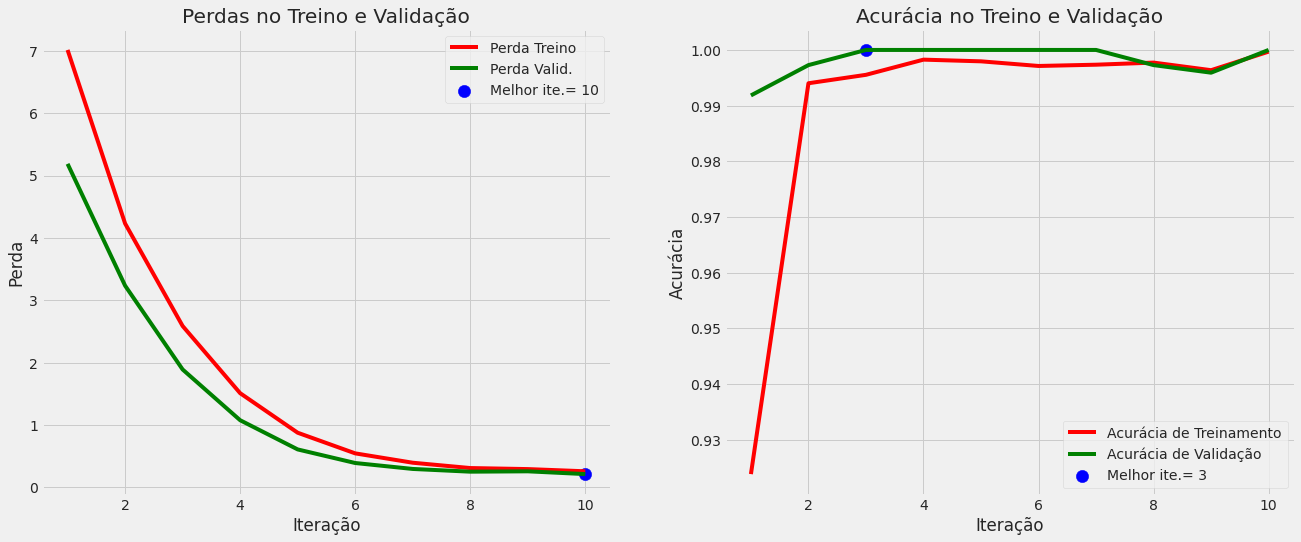

367/367 [==============================] - 48s 130ms/step - loss: 0.2132 - accuracy: 1.0000
acurácia no conjunto de teste é de 100.00 %



In [14]:
tr_plot(history,0)
save_dir=r'./'
subject='fruits'
acc=model.evaluate(test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'acurácia no conjunto de teste é de {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

### fazer previsões no conjunto de teste e gerar matriz de confusão e relatório de classificação

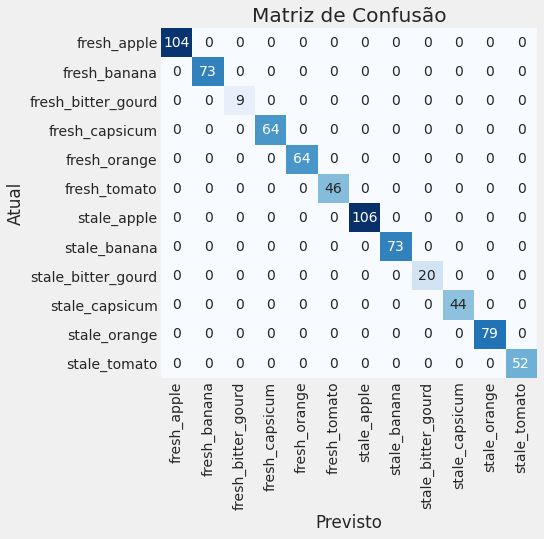

Relatório de Classificação:
----------------------
                     precision    recall  f1-score   support

       fresh_apple       1.00      1.00      1.00       104
      fresh_banana       1.00      1.00      1.00        73
fresh_bitter_gourd       1.00      1.00      1.00         9
    fresh_capsicum       1.00      1.00      1.00        64
      fresh_orange       1.00      1.00      1.00        64
      fresh_tomato       1.00      1.00      1.00        46
       stale_apple       1.00      1.00      1.00       106
      stale_banana       1.00      1.00      1.00        73
stale_bitter_gourd       1.00      1.00      1.00        20
    stale_capsicum       1.00      1.00      1.00        44
      stale_orange       1.00      1.00      1.00        79
      stale_tomato       1.00      1.00      1.00        52

          accuracy                           1.00       734
         macro avg       1.00      1.00      1.00       734
      weighted avg       1.00      1.00      1

In [15]:
print_code=0
preds=model.predict(test_gen) 
print_info( test_gen, preds, print_code, save_dir, subject )  